### Figure S5: Density plots

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [3]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38087/status,
Dashboard: /proxy/38087/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35313,Workers: 0
Dashboard: /proxy/38087/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42495,Total threads: 1
Dashboard: /proxy/32983/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:40121,


In [4]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4'
exp_extension = '01deg_jra55v140_iaf_cycle4_jra55v150_extension'

exp_ds = cat[experiment]
ext_ds = cat[exp_extension]

In [5]:
# Load model grid: 
walat = slice(-76,-63.99) # make sure t and u cells have same lengths
walon = slice(-140,-70)
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)

grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

hu = exp_ds.search(variable='hu').to_dask()['hu'].sel(yu_ocean=walat).sel(xu_ocean = walon).load()
ht = exp_ds.search(variable='ht').to_dask()['ht'].sel(yt_ocean=walat).sel(xt_ocean = walon).load()
area_t = exp_ds.search(variable='area_t').to_dask()['area_t'].sel(yt_ocean=walat).sel(xt_ocean = walon).fillna(0).load()
area_u = exp_ds.search(variable='area_u').to_dask()['area_u'].sel(yu_ocean=walat).sel(xu_ocean = walon).fillna(0).load()


In [6]:
# Load model output: 
start = '1984-01-01 00:00:00' # start date, 
end = '2019-01-01 00:00:00' # end date

# Load variables
t = exp_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end)) - 273.15

# Load extension with intake:
start_ext = '2019-01-01 00:00:00' 
end_ext = '2024-01-01 00:00:00' # end date

# Load other 3D variables:
t_ext = ext_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext)) - 273.15

In [7]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

In [8]:
# Concatenate and create annual
temp_full = xr.concat((t,t_ext),dim='time')
# Calculate annual
t_an = temp_full.resample({'time':'Y'}).mean('time')
t_climatology = t_an.mean('time')

In [9]:
# Load HVE and WMP
# Load WMP on gamma:
wmp_gamma = xr.open_dataset('/g/data/jk72/or6852/ensoant/cycle4_wmp_gamma_on_stocean.nc')['WMP']
hve_gamma = temp_full-temp_full.mean('time')-wmp_gamma

wmp_gamma_an = wmp_gamma.resample({'time':'Y'}).mean()
hve_gamma_an = t_an-t_an.mean('time')-wmp_gamma_an

In [10]:
# load gamma_xr 
gamma_xr = xr.open_dataset('/g/data/jk72/or6852/ensoant/cycle4_gamma_as_8401_2312.nc')['gamma']
gamma_an = gamma_xr.resample({'time':'Y'}).mean()

gamma_14 = gamma_an.sel(st_ocean = slice(100,400)).weighted(thickness).mean('st_ocean')

In [11]:
# Set mask for coastal box
pibs_mask = xr.where((ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).xt_ocean<-103.5) & (ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).yt_ocean>-74.5),np.nan,1)

hve_pibsa = (hve_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()
wmp_pibsa = (wmp_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()

In [12]:
# section:
sla2 = xr.DataArray(np.linspace(-71.1,-75.1, 91))
slo2 = xr.DataArray(np.linspace(-114.5,-101.2,91))
rho_sec_asb = gamma_an.sel(st_ocean = slice(0,1200)).sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').load()


In [14]:
# Define for plotting
land_u = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
land100 = xr.where(np.isnan(ht.where(ht>100).rename('land')), 1, np.nan)

In [15]:
# Plot parametres: define projection and boundary path, landmask

xt2d = xt_ocean.expand_dims({'yt_ocean':yt_ocean})
yt2d = yt_ocean.expand_dims({'xt_ocean':xt_ocean})

def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Eastern Amundsen for HVE-WMP
midlon = -107.5
maxlon = -95
minlon = -120
minlat = -75.609
maxlat = -70.509
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibm = make_boundary_path(lons, lats)
extent_pibm = [minlon,maxlon,minlat,maxlat]
projection_pibm = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)


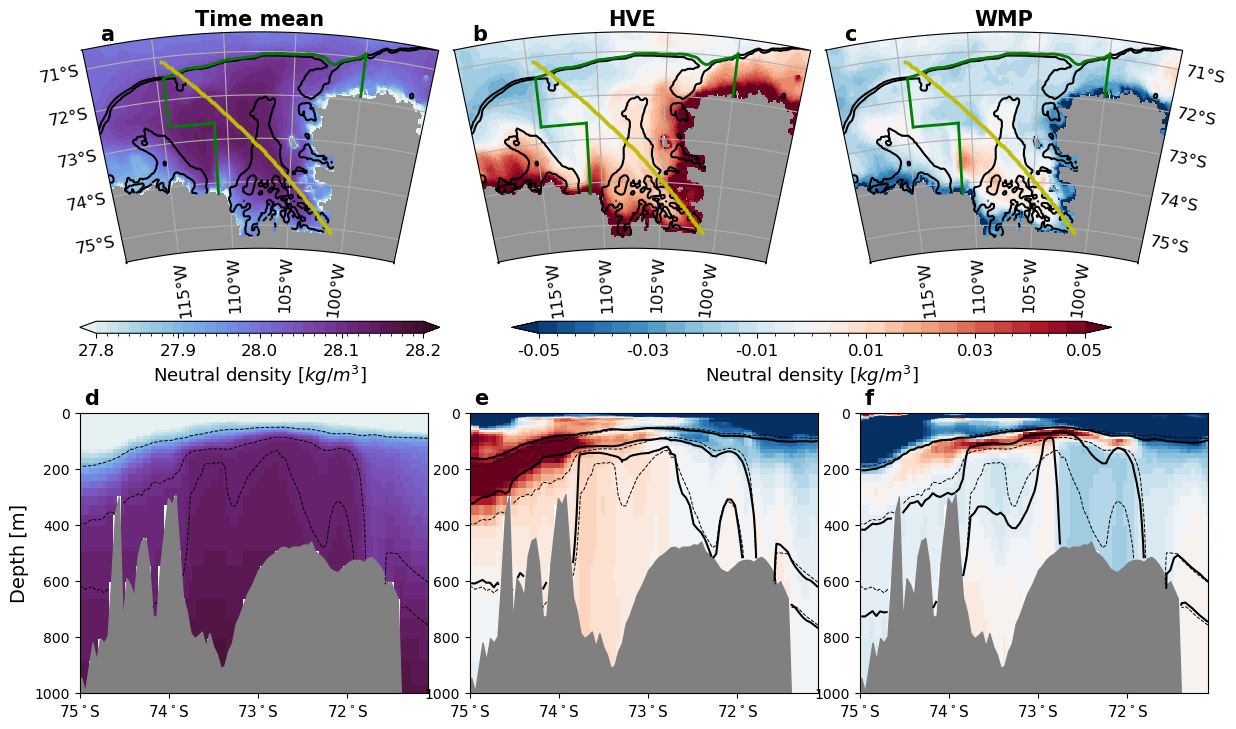

In [17]:
# Time averages and anomalies of gamma
compo_thres = 0.17
# Composites of density during years of high HVE / WMP
cvecg = np.linspace(-0.05,0.05,31)
fig = plt.figure(figsize=(12,8))
# Module: map of temperature anomalies during high HVE
ax1 = plt.axes([0.04,0.53,0.3,0.4],projection=projection_pibm) # Map of HVE
ax1.set_extent(extent_pibm, crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax1.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())    
p1 = gamma_14.mean('time').plot(ax=ax1,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(27.8,28.2,31), add_colorbar = False, cmap=cm.cm.dense, extend='both',
                    transform=ccrs.PlateCarree())
land100.plot(ax=ax1,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
p3 = ht.plot.contour(ax=ax1,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
# green box around the AS area
ax1.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax1.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax1.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax1.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax1,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
# indicate section
ax1.plot(slo2,sla2,color='y', ls='none', marker='o', markersize=2, transform=ccrs.PlateCarree())
ax1.text(-107.5,-70.4,'Time mean', horizontalalignment='center', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())
ax1.text(-118.5,-70.4,'a',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())

# Density section during high HVE
ax2 = plt.axes([0.04,0.06,0.29,0.35])
p1 = rho_sec_asb.mean('time').plot(ax=ax2, x='yt_ocean',y='st_ocean',levels = np.linspace(27.8,28.2,31), add_colorbar = False, cmap=cm.cm.dense, extend='both',)
rho_sec_asb.mean('time').plot.contour(ax=ax2, x='yt_ocean',y='st_ocean',levels = [27.9,28.1,28.13], colors='k', linestyles='--', linewidths=0.7)
ax2.fill_between(ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').yt_ocean,1500,ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest'),color='grey')
ax2.set_ylim([1000,0])
ax2.set_xlim([-75,-71.1])
ax2.set_ylabel('Depth [m]', fontsize=14)
ax2.set_xlabel('', fontsize=14)
ax2.set_xticks([-75,-74,-73,-72],['75$^\circ$S','74$^\circ$S','73$^\circ$S','72$^\circ$S'])
ax2.tick_params('x', colors='k', labelsize=11)
ax2.text(-74.95,-30,'d',color='k',fontsize=15,fontweight='bold')
#ax2.set_title('HVE', fontsize = 15, fontweight = 'bold')

# Density colorbar
axin = plt.axes([0.04,0.51,0.3,0.015])
cb=plt.colorbar(p1,cax=axin, ticks=np.arange(27.8,28.3,0.1),orientation='horizontal',aspect = 50)
cb.set_label('Neutral density [$kg/m^3$]',fontsize=13)
#cb.tick_params('y', labelsize=14)
cb.set_ticks(np.arange(27.8,28.3,0.1), labels=np.round(np.arange(27.8,28.3,0.1),1),fontsize=12)


ax3 = plt.axes([0.35,0.53,0.3,0.4],projection=projection_pibm) # Map of HVE
ax3.set_extent(extent_pibm, crs=ccrs.PlateCarree())
gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax3.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())    
p1 = (gamma_14-gamma_14.mean('time')).where(hve_pibsa.rolling(time=3,center=True).mean('time')>compo_thres).mean('time').plot(ax=ax3,
                    x='xt_ocean', y='yt_ocean', levels = cvecg, add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
land100.plot(ax=ax3,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
p3 = ht.plot.contour(ax=ax3,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
# green box around the AS area
ax3.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax3,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
# indicate section
ax3.plot(slo2,sla2,color='y', ls='none', marker='o', markersize=2, transform=ccrs.PlateCarree())
ax3.text(-107.5,-70.4,'HVE', horizontalalignment='center', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())
ax3.text(-118.5,-70.4,'b',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())

# Density section during high HVE
ax4 = plt.axes([0.365,0.06,0.29,0.35])
p1 = (rho_sec_asb-rho_sec_asb.mean('time')).where(hve_pibsa.rolling(time=3,center=True).mean('time')>compo_thres).mean('time').plot(ax=ax4, x='yt_ocean',y='st_ocean',levels = cvecg, add_colorbar = False, cmap='RdBu_r', extend='both',)
rho_sec_asb.where(hve_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time').plot.contour(ax=ax4, x='yt_ocean',y='st_ocean',levels = [27.9,28.1,28.13], colors='k')
rho_sec_asb.mean('time').plot.contour(ax=ax4, x='yt_ocean',y='st_ocean',levels = [27.9,28.1,28.13], colors='k', linestyles='--', linewidths=0.7)
ax4.fill_between(ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').yt_ocean,1500,ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest'),color='grey')
ax4.set_ylim([1000,0])
ax4.set_xlim([-75,-71.1])
ax4.set_ylabel('', fontsize=14)
ax4.set_xlabel('', fontsize=14)
ax4.set_xticks([-75,-74,-73,-72],['75$^\circ$S','74$^\circ$S','73$^\circ$S','72$^\circ$S'])
ax4.tick_params('x', colors='k', labelsize=11)
ax4.text(-74.95,-30,'e',color='k',fontsize=15,fontweight='bold')
#ax2.set_title('HVE', fontsize = 15, fontweight = 'bold')

#WMP:
ax5 = plt.axes([0.66,0.53,0.3,0.4],projection=projection_pibm) # Map of HVE
ax5.set_extent(extent_pibm, crs=ccrs.PlateCarree())
gl = ax5.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.left_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax5.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())   
p1 = (gamma_14-gamma_14.mean('time')).where(wmp_pibsa.rolling(time=3,center=True).mean('time')>compo_thres).mean('time').plot(ax=ax5,
                    x='xt_ocean', y='yt_ocean', levels = cvecg, add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
land100.plot(ax=ax5,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
p3 = ht.plot.contour(ax=ax5,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
# green box around the AS area
ax5.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax5.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax5.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax5.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax5,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
# indicate section
ax5.plot(slo2,sla2,color='y', ls='none', marker='o', markersize=2, transform=ccrs.PlateCarree())
ax5.text(-107.5,-70.4,'WMP', horizontalalignment='center', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())
ax5.text(-118.5,-70.4,'c',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())

# Temperature section during high WMP
ax6 = plt.axes([0.69,0.06,0.29,0.35])
p1 = (rho_sec_asb-rho_sec_asb.mean('time')).where(wmp_pibsa.rolling(time=3,center=True).mean('time')>compo_thres).mean('time').plot(ax=ax6, x='yt_ocean',y='st_ocean',levels = cvecg, add_colorbar = False, cmap='RdBu_r', extend='both',)
rho_sec_asb.where(wmp_pibsa.rolling(time=3,center=True).mean()>compo_thres).mean('time').plot.contour(ax=ax6, x='yt_ocean',y='st_ocean',levels = [27.9,28.1,28.13], colors='k')
rho_sec_asb.mean('time').plot.contour(ax=ax6, x='yt_ocean',y='st_ocean',levels = [27.9,28.1,28.13], colors='k', linestyles='--', linewidths=0.7)
ax6.fill_between(ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest').yt_ocean,1500,ht.sel(xt_ocean = slo2, yt_ocean = sla2, method='nearest'),color='grey')
ax6.set_ylim([1000,0])
ax6.set_xlim([-75,-71.1])
ax6.set_ylabel('', fontsize=14)
ax6.set_xlabel('', fontsize=14)
ax6.set_xticks([-75,-74,-73,-72],['75$^\circ$S','74$^\circ$S','73$^\circ$S','72$^\circ$S'])
ax6.tick_params('x', colors='k', labelsize=11)
ax6.text(-74.95,-30,'f',color='k',fontsize=15,fontweight='bold')
# Temperature colorbar
axin = plt.axes([0.4,0.51,0.5,0.015])
cb=plt.colorbar(p1,cax=axin,ticks=np.arange(-0.05,0.07,0.02),orientation='horizontal',aspect = 50)
cb.set_label('Neutral density [$kg/m^3$]',fontsize=13)
#cb.tick_params('y', labelsize=14)
cb.set_ticks(np.arange(-0.05,0.07,0.02), labels=np.round(np.arange(-0.05,0.07,0.02),2),fontsize=12)

#plt.savefig('/home/581/or6852/plots/figures/supplement_gamma.png')